# KeepUp Data Science Challenge

## Part A

In [2]:
import pandas as pd
import gzip

In [4]:
d = {'Id':[], 'ASIN':[], 'title':[], 'group':[], 'salesrank':[], 'similar':[], 'categories':[], 'reviews':[]}

def split_line(line):
    """
    Helper function to split line on colon and return name and value.
    """
    name = line.split(': ')[0].strip()
    
    #Check if name is in the keys of the master dictionary
    if name not in d.keys():
        return 0
    try:
        value = line.split(': ')[1:len(line.split(': '))]      
    #IndexError if splitting on line like "discontinued product"
    except IndexError:
        return 0
    return (name, value)  

def update_master_dict(line_dict):
    """
    Helper function to update master dictionary with a completed row.
    """
    for key in d.keys():
        d[key].append(line_dict[key])
        
status = 0
id_dict = {}

with gzip.open('amazon-meta.txt.gz') as f:
    for line in f.read().splitlines():
        line = line.decode("utf-8")
        
        #If name, value pair returned and status is not looking for multi-lines
        if split_line(line) != 0 and status == 0:
            (name, value) = split_line(line)
            if name == 'Id':
                #Initialize row dictionary
                id_dict = {name: value[0].strip()} 
            if 'categories' in name:
                #Determine number of following rows to include
                rows = int(value[0])
                if rows > 0:
                    (i, status, compiled_rows) = (0, 1, [])
                else:
                    #If no categories returned, set value to 0
                    id_dict[name] = 0  
            if 'reviews' in name:
                #Determine number of following rows to include
                rows = int(value[2].split()[0])
                if rows > 0:
                    (i, status, compiled_rows) = (0, 1, [])
                else:
                    #If no categories returned, set value to 0
                    id_dict[name] = 0 
            else:
                #If any other column besides reviews, categories or ID, just add value
                id_dict[name] = value[0].strip()
                
        #If collecting multi-lines
        elif status == 1:
            compiled_rows.append(line.strip())
            i += 1
            #If collected all lines to match number of rows, add lines as value and reset status
            if i == rows:
                id_dict[name] = compiled_rows
                status = 0 
        else:
            #If reached end of row, reset status to looking for next ID
            status = 0
            
            #If entire row collected, add to master dictionary
            if len(id_dict) == len(d):
                update_master_dict(id_dict)
            id_dict = {}

#Create dataframe from master dictionary          
df = pd.DataFrame.from_dict(d) 
df.head()

,ASIN,Id,categories,group,reviews,salesrank,similar,title
0,0827229534,1,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,[2000-7-28 cutomer: A2JW67OY8U6HHK rating: 5...,396585,5 0804215715 156101074X 0687023955 0687074...,Patterns of Preaching
1,0738700797,2,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,[2001-12-16 cutomer: A11NCO6YTE4BTJ rating: ...,168596,5 0738700827 1567184960 1567182836 0738700...,Candlemas
2,0486287785,3,[|Books[283155]|Subjects[1000]|Home & Garden[4...,Book,[2003-7-10 cutomer: A3IDGASRQAW8B2 rating: 5...,1270652,0,World War II Allied Fighter Planes Trading Cards
3,0842328327,4,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,[2004-8-19 cutomer: A2591BUPXCS705 rating: 4...,631289,5 0842328130 0830818138 0842330313 0842328...,Life Application Bible Commentary
4,1577943082,5,[|Books[283155]|Subjects[1000]|Religion & Spir...,Book,0,455160,5 157794349X 0892749504 1577941829 0892749...,Prayers That Avail Much for Business


**1) Trustworthiness of ratings**

**Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?**

In [6]:
#Understand if reviews are mainly 5's
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

all_ratings = []

#Gather all ratings into one list
for e in df.reviews:
    if e != 0:
        for i in e:
            rating = int(i.split()[4])
            all_ratings.append(rating)

In [23]:
from collections import Counter

Counter(all_ratings).most_common(5)

[(5, 4564259), (4, 1401990), (3, 627917), (1, 583766), (2, 415312)]

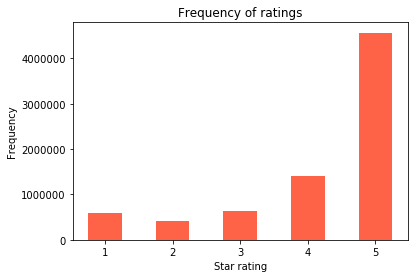

In [27]:
#Plot histogram of ratings
plt.hist(all_ratings, align = 'left', bins = [1, 2, 3, 4, 5, 6], rwidth = 0.5, color = 'tomato');
plt.title('Frequency of ratings');
plt.ylabel('Frequency');
plt.xlabel('Star rating');

The vast majority of reviews are 4's and 5's, showing that either consumers buy only products they already know they will enjoy or only take the time to review if they have a strong positive opinion.

**2) Category bloat**

**Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.**

**For this dataset, quantify the following:**

**a. Is there redundancy in the categorization? How can it be identified/removed?**

**b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?**

In [142]:
df.categories[0]

['|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]']

I would consider the very first categories entry to be redundant.  A sermon is a form of preaching and does not need its own category. Redundancy could be identified by determining if a category is always paired or grouped with others.  If so, then it has no need to stand on its own.

In [161]:
#We'll run an example from the first entry
category = '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'

def find_grouped_categories(category):
    """
    Runs through all category entrys and compiles a list of category paths that appear with the category given.
    Returns list of category paths and number of appearances of given category in database.
    """
    matches = []
    appearances = 0
    
    for e in df.categories:
        if category in e:
            appearances += 1
            for i in e:
                if i != category:
                    matches.append(i)
    return matches, appearances

def find_redundant_cats(category, redundancy):
    """
    Determines if any categories appear enough times with category given to be considered redundant.
    Returns categories that appear at a frequency given by "redundancy" input (ex. 0.5).
    """
    matches, appearances = find_grouped_categories(category)
    
    #Define number of appearances to be considered redundant
    redundant_appearances = appearances * redundancy
    redundant_cats = []
    
    #Find frequencies of matched categories and determine if number of appearances hits threshold for redundancy
    for tup in Counter(matches).most_common():
        if tup[1] >= redundant_appearances:
            redundant_cats.append(tup[0])
    return redundant_cats

In [162]:
find_redundant_cats(category, 0.5)

[]

No redundant categories if we consider appearing half the time together as redundant.

In [165]:
find_redundant_cats(category, 0.33)

['|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Other Practices[12761]|Ritual[12771]',
 '|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]']

However, this category would be considered redundant if redundancy were defined as one-third as two categories appear one-third as many times as the category at hand.

In [166]:
#Aggregate all category paths into one list
all_cats = []
for e in df.categories:
    if e!= '0':
        for i in e:
            if 'Books' in i:
                all_cats.append(i)

#Find unique paths and their frequencies
freq_last_cat = Counter(all_cats).most_common()

#Total number of category paths
print('Total unique category paths:', len(freq_last_cat))

#Total paths to remove to reduce to 10%
print('Paths to remove to reduce to 10%: {:.0f}'.format(0.9 * len(freq_last_cat)))

Total unique category paths: 12627
Paths to remove to reduce to 10%: 11364


In [167]:
#Look at category frequencies
freq_last_cat

[('|[265523]|Amazon.com Stores[285080]|Home & Office[764512]|Business & Investing Books[767740]|General[767880]',
  18439),
 ('|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612]',
  18437),
 ('|Books[283155]|Subjects[1000]|Reference[21]|General[408268]', 13703),
 ('|Books[283155]|Subjects[1000]|Biographies & Memoirs[2]|General[2375]',
  12243),
 ('|Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|General[11289]',
  11779),
 ('|Books[283155]|Subjects[1000]|Literature & Fiction[17]|General[10125]|Contemporary[10129]',
  11448),
 ("|Books[283155]|Subjects[1000]|Children's Books[4]|Ages 4-8[2785]|General[170062]",
  11439),
 ('|Books[283155]|Subjects[1000]|Nonfiction[53]|Education[10605]|General[10635]',
  8762),
 ('|Books[283155]|Subjects[1000]|Computers & Internet[5]|General[657762]',
  8661),
 ('|Books[283155]|Subjects[1000]|Health, Mind & Body[10]|Psychology & Counseling[11119]|General[11175]',
  8064),
 ("|Books[283155]|Subjects[1000

In [168]:
#Look at least common categories
freq_last_cat[len(freq_last_cat)-500:len(freq_last_cat)-1]

[('|Books[283155]|Subjects[1000]|Science Fiction & Fantasy[25]|Authors, A-Z[14652]|( B )[14711]|Bergstrom, Elaine[14783]',
  1),
 ('|Books[283155]|Subjects[1000]|Horror[49]|Authors, A-Z[5439]|( R )[8574]|Rickman, Phil[8673]',
  1),
 ('|Books[283155]|Subjects[1000]|Horror[49]|Authors, A-Z[5439]|( H )[6918]|Hoffman, Barry[7142]',
  1),
 ('|Books[283155]|Specialty Stores[504360]|Foreign Language Books[3118571]|More Languages[3198801]|Farsi[3151781]',
  1),
 ('|Books[283155]|Formats[504358]|Books on Tape[44]|Authors, A-Z[287120]|( B )[287122]|Byatt, A. S.[585946]',
  1),
 ("|Books[283155]|Subjects[1000]|Children's Books[4]|Authors & Illustrators, A-Z[170540]|( L )[170552]|Lee, Dennis[170741]",
  1),
 ('|Books[283155]|Subjects[1000]|History[9]|Middle East[4995]|Qatar[5006]', 1),
 ('|Books[283155]|Subjects[1000]|Arts & Photography[1]|Artists, A-Z[1104]|( G-I )[1227]|Gericault, Theodore[1237]',
  1),
 ('|Books[283155]|Subjects[1000]|Comics & Graphic Novels[4366]|Manga[4367]|Horror[13436181]',

In [170]:
#Look at commonality in list
least_freq_count = 0
for tup in freq_last_cat:
    if tup[1] < 200:
        least_freq_count +=1
print('Number of categories removed if membership threshold set at 200:', least_freq_count)

Number of categories removed if membership threshold set at 200: 11120


We see that by removing all categories with frequencies of less than 200, we can cut down the number of categories to 10% of the original. 

## Part B

**1) Algorithm thinking**

**How would you build the product categorization from scratch, using similar/co-purchased
information? **

I would gather all categories for the similar items and identify if any categories overlap.  If so, I would include them in the categorization for the item at hand.

**2) Product thinking**

**Now, put on your 'product thinking' hat.**

**a. Is it a good idea to show users the categorization hierarchy for items?**

**b. Is it a good idea to show users similar/co-purchased items?**

**c. Is it a good idea to show users reviews and ratings for items?**

**d. For each of the above, why? How will you establish the same?**

a. Yes, because it would allow users to understand the topics they are interested in. If they want to buy a book with the |Books[283155]|Subjects[1000]|Home & Garden[48]|Animal Care & Pets[5043]|Dogs[5049]|General[5052] category, they could search within the category to find other relevant books.

b. Yes, if a user is at a product but it's not quite what they're looking for, the similar/co-purchased items list can be helpful in identifying items that may be closer to what they want.

c. Yes, for example, if I wanted to buy a table and found one that looked beautiful but all the reviews said the table fell apart after a few days, I would not buy the table and most likely have higher customer satisifaction than if I had bought a faulty product.  It's better to have lost a customer than to have an irate one.

d. We can establish that all of the above are good ideas through A/B testing and show customers one version of the page with the reviews or the categories or the similar list and one without and determine which has the higher rate of conversions.  We can also experiment using the same approach with the combination of items on the page.  Perhaps, showing the categorization and the similar list but not reviews results in a higher conversion rate.  Or that showing the reviews but not the categorization or the similar list results in a higher conversion rate.